In [1]:
import numpy as np
import simphony.core as core
import simphony.errors as errors
import simphony.DeviceLibrary.ebeam as dev
import simphony.DeviceLibrary.ann as ann
import simphony.simulation as sim

import matplotlib.pyplot as plt
from scipy import special
import dill

In [2]:
def bezier(x,b):
    def bernstein(n, j, t):
        return special.binom(n, j) * t ** j * (1 - t) ** (n - j)
    n = len(x)-1
    return {'g': x,
            'w': b,
            'f': lambda t: np.sum(np.array([(x[j])*bernstein(n,j,t/b) for j in range(len(x))]),axis=0),
            'df': lambda t: np.sum(np.array([n*(x[j]/2)*(bernstein(n-1,j-1,t/b)-bernstein(n-1,j,t/b)) for j in range(len(x))]),axis=0)/b,
            'd2f': lambda t: np.sum(np.array([n*(n-1)*(x[j]/2)*(bernstein(n-2,j-2,t/b)-2*bernstein(n-2,j-1,t/b)+bernstein(n-2,j,t/b)) for j in range(len(x))]),axis=0)/b**2}

## Get the Through Port of a Racetrack Resonator using SiPANN and Simphony

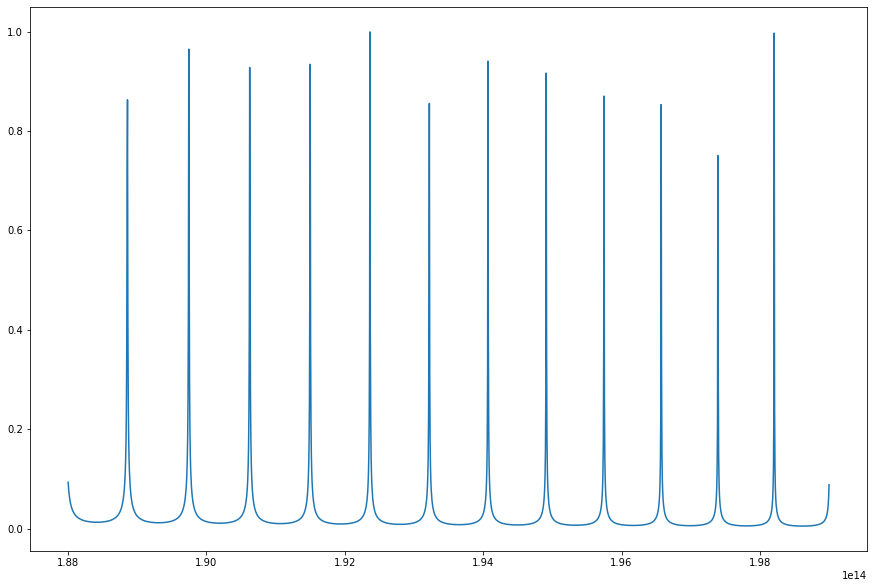

In [3]:
radius = 12
length = 4.5

bottom = core.ComponentInstance(ann.sipann_dc_halfracetrack, extras=
                                {'radius': radius, 'length': length, 'gap': 0.3})

top    = core.ComponentInstance(ann.sipann_dc_halfracetrack, extras=
                                {'radius': radius, 'length': length, 'gap': 0.3})

c1 = [bottom, bottom]
p1 = [1, 3]
c2 = [top, top]
p2 = [1, 3]

con = zip(c1, p1, c2, p2)

nl = core.Netlist()
nl.load(con, formatter='ll')
simu = sim.Simulation(nl)

freq = simu.freq_array
sparams = simu.s_parameters()


plt.figure(figsize=(15,10))
plt.plot(freq, np.abs(sparams[:,0,2]))
plt.show()

## Get the Cross Port of a 20/80 Optimized Directional Coupler

Note: This one may take a while to run. Also, am getting a weird list error that seems to be on Simphony's side of things...

In [4]:
with open('dc.pkl', 'rb') as handle:
    dic = dill.load(handle)

pts = dic['g']
zmin = 0
zmax = dic['w']
dic = bezier(pts, zmax)
gap = dic['f']
dgap = dic['df']


dc = core.ComponentInstance(ann.sipann_dc_arbitrarysym, extras=
                            {'gap': gap, 'dgap': dgap, 'zmin': zmin, 'zmax': zmax})
wg = core.ComponentInstance(dev.ebeam_wg_integral_1550)

c1 = [dc]
p1 = [1]
c2 = [top]
p2 = [0]

con = zip(c1, p1, c2, p2)

nl = core.Netlist()
nl.load(con, formatter='ll')
simu = sim.Simulation(nl, num=50)

freq = simu.freq_array
sparams = simu.s_parameters()


plt.figure(figsize=(15,10))
plt.plot(freq, np.abs(sparams[:,0,3]))
plt.show()

/home/contagon6/Documents/SiP-ANN/SiPANN/dc.py:213: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "predict" failed type inference due to: Untyped global name 'get_coeffs': cannot determine Numba type of <class 'function'>

File "../../../SiP-ANN/SiPANN/dc.py", line 218:
    def predict(self, ports, wavelength, extra_arc=0, part='both'):
        <source elided>
        n = len(wavelength)
        ae, ao, ge, go, neff = get_coeffs(wavelength, width, thickness, sw_angle)
        ^

  @jit
/home/contagon6/Documents/SiP-ANN/SiPANN/dc.py:213: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "predict" failed type inference due to: Untyped global name 'get_coeffs': cannot determine Numba type of <class 'function'>

File "../../../SiP-ANN/SiPANN/dc.py", line 218:
    def predict(self, ports, wavelength, extra_arc=0, part='both'):
        <source elided>
        n = len(wavelength)
       

NotImplementedError: Class is not cachable and s_parameters is not a function.

In [39]:
from SiPANN import dc

test = dc.GapFuncSymmetric(500, 220, gap, dgap, zmin, zmax)
%timeit test.sparams(np.linspace(1500,1600,50))

KeyboardInterrupt: 